# Semantic Chunking for RAG

https://medium.com/the-ai-forum/semantic-chunking-for-rag-f4733025d5f5

Different chunk methods:

* Fixed size Chunking
* Recursive Chunking
* Document Specific Chunking
* Semantic Chunking
* Agentic Chunking

**Semantic Chunking:** Involves taking the embeddings of every sentence in the document, comparing the similarity of all sentences with each other, and then grouping them with the most similar embeddings together. It focuses on the text's semantic and context.

Involves taking the embeddings of every sentence in the document, comparing the similarity of all sentences with each other, and then grouping them with the most similar embeddings together. It focuses on the text's semantic and context.

## Download data

In [1]:
!wget "https://arxiv.org/pdf/1810.04805.pdf"

--2025-07-29 03:31:44--  https://arxiv.org/pdf/1810.04805.pdf
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.3.42, 151.101.195.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/1810.04805 [following]
--2025-07-29 03:31:44--  http://arxiv.org/pdf/1810.04805
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775166 (757K) [application/pdf]
Saving to: ‘1810.04805.pdf’

1810.04805.pdf      100%[===================>] 757.00K  --.-KB/s    in 0.06s   

2025-07-29 03:31:44 (11.9 MB/s) - ‘1810.04805.pdf’ saved [775166/775166]



## Install modules

In [22]:
!pip install -q langchain-community pypdf fastembed langchain_groq langchain_experimental langchain-openai chromadb ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.4 MB/s eta 0:00:00


In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [4]:
document_path = "1810.04805.pdf"
loader = PyPDFLoader(document_path)
documents = list(loader.lazy_load())

print(len(documents))

16


## Native chunking (RecursiveCharacterTextSplitter)

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

naive_chunks = text_splitter.split_documents(documents)

for chunk in naive_chunks[:3]:
    print(chunk.page_content, "\n")

BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
Jacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova
Google AI Language
{jacobdevlin,mingweichang,kentonl,kristout}@google.com
Abstract
We introduce a new language representa-
tion model called BERT, which stands for
Bidirectional Encoder Representations from
Transformers. Unlike recent language repre-
sentation models (Peters et al., 2018a; Rad-
ford et al., 2018), BERT is designed to pre-
train deep bidirectional representations from
unlabeled text by jointly conditioning on both
left and right context in all layers. As a re-
sult, the pre-trained BERT model can be ﬁne-
tuned with just one additional output layer
to create state-of-the-art models for a wide
range of tasks, such as question answering and
language inference, without substantial task-
speciﬁc architecture modiﬁcations.
BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art re- 

sults on eleven natural la

## Semantic Chunking

In [6]:
# Instantiate embedding model

from langchain_community.embeddings import FastEmbedEmbeddings

embed_model = FastEmbedEmbeddings()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

In [7]:
%%time

from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(embed_model, breakpoint_threshold_type="percentile")

semantic_chunks = semantic_chunker.create_documents([doc.page_content for doc in documents])

CPU times: user 2min 11s, sys: 465 ms, total: 2min 12s
Wall time: 2min 13s


In [8]:
for semantic_chunk in semantic_chunks:
    page_content: str = semantic_chunk.page_content
    if "Effect of Pre-training Tasks" in page_content:
        print(page_content)
        print(len(page_content))
        break

Dev Set
Tasks MNLI-m QNLI MRPC SST-2 SQuAD
(Acc) (Acc) (Acc) (Acc) (F1)
BERTBASE 84.4 88.4 86.7 92.7 88.5
No NSP 83.9 84.9 86.5 92.6 87.9
LTR & No NSP 82.1 84.3 77.5 92.1 77.8
+ BiLSTM 82.1 84.1 75.7 91.6 84.9
Table 5: Ablation over the pre-training tasks using the
BERTBASE architecture. “No NSP” is trained without
the next sentence prediction task. “LTR & No NSP” is
trained as a left-to-right LM without the next sentence
prediction, like OpenAI GPT. “+ BiLSTM” adds a ran-
domly initialized BiLSTM on top of the “LTR + No
NSP” model during ﬁne-tuning. ablation studies can be found in Appendix C. 5.1 Effect of Pre-training Tasks
We demonstrate the importance of the deep bidi-
rectionality of BERT by evaluating two pre-
training objectives using exactly the same pre-
training data, ﬁne-tuning scheme, and hyperpa-
rameters as BERTBASE :
No NSP: A bidirectional model which is trained
using the “masked LM” (MLM) but without the
“next sentence prediction” (NSP) task. LTR & No NSP: A left-cont

## RAG for Semantic Chunking Strategy

In [9]:
# Instantiate vector store

from langchain_community.vectorstores import Chroma

semantic_vector_store = Chroma.from_documents(semantic_chunks, embedding=embed_model)

In [10]:
semantic_retriever = semantic_vector_store.as_retriever(search_kwargs={"k": 1})

query: str = "Describe the Feature-based Approach with BERT?"

semantic_retriever.invoke(query)

[Document(metadata={}, page_content='BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\nJacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova\nGoogle AI Language\n{jacobdevlin,mingweichang,kentonl,kristout}@google.com\nAbstract\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be ﬁne-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task-\nspeciﬁc architecture modiﬁcations. BERT is conceptually simple and empirically\npowerful. It obt

In [11]:
from google.colab import userdata

groq_api_key = userdata.get('GROQ_API_KEY')

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

template: str = """
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatGroq(
    temperature=0,
    model="llama-3.1-8b-instant",
    api_key=groq_api_key
)

In [13]:
# Pipeline chain for Semantic Chunking

from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

semantic_rag_chain = (
    {"context": semantic_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

queries: list[str] = [query, "What is SQuADv2.0?", "What is the purpose of Ablation Studies?"]

semantic_responses: list[str] = semantic_rag_chain.batch(queries)

In [14]:
for question, answer in zip(queries, semantic_responses):
    print(f"Q: {question}", answer, sep="\n", end=f"\n\n{'='*100}\n\n")

Q: Describe the Feature-based Approach with BERT?
The Feature-based Approach with BERT refers to a strategy for applying pre-trained language representations to downstream tasks. In this approach, task-specific architectures are designed to include the pre-trained BERT representations as additional features.

This means that the pre-trained BERT model is used to generate contextualized word embeddings, which are then fed into a separate task-specific model to perform the downstream task. The task-specific model is trained on the downstream task, but it relies on the pre-trained BERT representations to capture the contextual relationships between words.

The Feature-based Approach with BERT is often used in conjunction with other pre-trained language models, such as ELMo (Peters et al., 2018a). This approach allows for the use of pre-trained representations in a wide range of tasks, including question answering, language inference, and named entity recognition.

However, the Feature-bas

## RAG for Naive Chunking Strategy

In [15]:
naive_vector_store = Chroma.from_documents(naive_chunks, embedding=embed_model)

naive_retriever = naive_vector_store.as_retriever(search_kwargs={"k": 1})

naive_rag_chain = (
    {"context": naive_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [16]:
naive_responses = naive_rag_chain.batch(queries)

for question, answer in zip(queries, naive_responses):
    print(f"Q: {question}", answer, sep="\n", end=f"\n\n{'='*100}\n\n")

Q: Describe the Feature-based Approach with BERT?
The Feature-based Approach with BERT involves extracting contextual embeddings from one or more layers of the pre-trained BERT model without fine-tuning any of its parameters. These extracted embeddings are then used as input to a randomly initialized two-layer 768-dimensional Bidirectional Long Short-Term Memory (BiLSTM) network before the classification layer. This approach leverages the pre-trained knowledge of BERT to improve the performance of the model on a specific task.


Q: What is SQuADv2.0?
SQuADv2.0 is an extension of the SQuAD 1.1 problem definition, which allows for the possibility that no short answer exists in the provided paragraph. This makes the problem more realistic.


Q: What is the purpose of Ablation Studies?
The purpose of Ablation Studies in this context is to evaluate the effect of different factors on the performance of a model, specifically BERT in this case. 

In the given context, Ablation Studies are used

## Ragas Assessment Comparison for Semantic Chunker

In [17]:
synthetic_data_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

synthetic_data_chunks = synthetic_data_splitter.create_documents(
    [d.page_content for d in documents]
)

print(len(synthetic_data_chunks))

72


Create dataset containing:
* Questions
* Contexts
* GroundTruths
* Answers

In [19]:
question_template: str = """
You are a teacher preparing a test. Please create a question that can be answered by referencing the following context.

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_template)

ground_truth_template = """
Use the following context and question to answer this question using *only* the provided context.

Question:
{question}

Context:
{context}
"""

question_chain = question_prompt | llm | StrOutputParser()

ground_truth_prompt = ChatPromptTemplate.from_template(ground_truth_template)
ground_truth_chain = ground_truth_prompt | llm | StrOutputParser()

questions, contexts, ground_truths_semantic, answers = [], [], [], []

for chunk in synthetic_data_chunks[10:20]:
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(
      ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]})
  )
  answers.append(semantic_rag_chain.invoke(questions[-1]))

In [24]:
# Format the content generated into HuggingFace Dataset Format

from datasets import load_dataset, Dataset

qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
    qagc_list.append({
        "question": question,
        "answer": answer,
        "retrieved_contexts": context,
        "ground_truth": ground_truth
     })

eval_dataset = Dataset.from_list(qagc_list)
eval_dataset

Dataset({
    features: ['question', 'answer', 'retrieved_contexts', 'ground_truth'],
    num_rows: 10
})

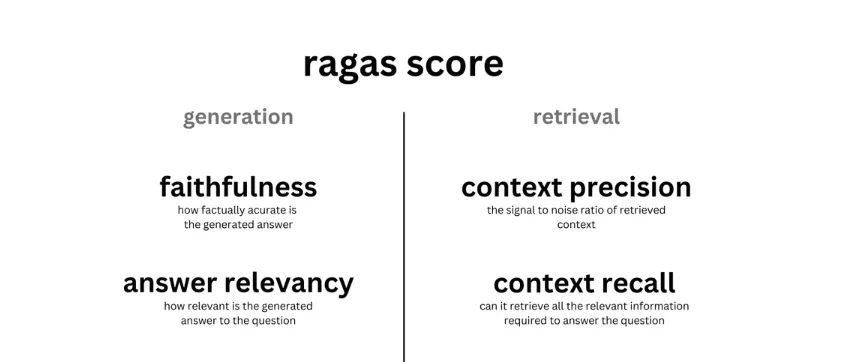

In [30]:
from google.colab import userdata

from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

result = evaluate(
    eval_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
    #llm=llm,
    embeddings=embed_model,
    raise_exceptions=False
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
result

{'context_precision': 1.0000, 'faithfulness': 0.6388, 'answer_relevancy': 0.8398, 'context_recall': 1.0000}

## Ragas Assessment Comparison for Naive Chunker

In [32]:
questions, contexts, ground_truths_semantic, answers = [], [], [], []

for chunk in synthetic_data_chunks[10:20]:
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(
      naive_rag_chain.invoke({"question" : questions[-1], "context" : contexts[-1]})
  )
  answers.append(semantic_rag_chain.invoke(questions[-1]))

In [33]:
qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
    qagc_list.append({
        "question": question,
        "answer": answer,
        "retrieved_contexts": context,
        "ground_truth": ground_truth
     })

eval_dataset = Dataset.from_list(qagc_list)

result = evaluate(
    eval_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
    #llm=llm,
    embeddings=embed_model,
    raise_exceptions=False
)

result

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

{'context_precision': 0.9000, 'faithfulness': 0.6175, 'answer_relevancy': 0.8606, 'context_recall': 0.8000}

## Conclusion

Based on the Ragas assessment, **Semantic Chunking** generally performed better than **Naive Chunking**, particularly in retrieving relevant and complete context (higher context precision and recall). Faithfulness scores were similar for both, indicating potential areas for improvement in factual consistency of generated answers.